# With CKKS encrypted linear regression

The encrypted linear regression follows the code from the plain linear regression, which is based on the exercises of the ADML module by Solange Emmenegger (Solange Emmenegger, Hochschule Luzern, Module Advanced Machine Learning, accessed on 19 April 2024 at https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/tree/master/notebooks/03A%20Supervised%20Learning, and https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/blob/master/notebooks/04B%20Gradient%20Descent/Gradient%20Descent.ipynb).

The dataset Apartment rental offers in Germany from kaggle (https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany) is used with the same parameters as the linear regression. The main difference with the plain linear regression is that CKKS encrypted tensors and operations are used to train the linear regression on encrypted data.

Firstly, the libraries are imported.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from time import time
import psutil

from tqdm.notebook import tqdm
from collections import defaultdict

import tenseal as ts


%matplotlib inline

## Data cleaning

In this section, the dataset is prepared for processing. The following actions are performed:

- Amount of features reduced
- Data converted to appropriate datatypes
- Unsensical data is removed
- NA values are removed
- Outliers are removed as linear regression is sensitive to outliers
- Categorical data is converted to numeric data
- The data is split into a train and test set
- The data is scaled as linear regression is sensitive to data ranges.

The code leans on the exercises from the module ADML (https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/tree/master/notebooks/03A%20Supervised%20Learning).## Data cleaning

In this section, the dataset is prepared for processing. The following actions are performed:

- Amount of features reduced
- Data converted to appropriate datatypes
- Unsensical data is removed
- NA values are removed
- Outliers are removed as linear regression is sensitive to outliers
- Categorical data is converted to numeric data
- The data is split into a train and test set
- The data is scaled as linear regression is sensitive to data ranges.

The code leans on the exercises from the module ADML (https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/tree/master/notebooks/03A%20Supervised%20Learning).

In [38]:
df = pd.read_csv("immo_data.csv")

columns_to_drop = ['serviceCharge', 'telekomTvOffer', 'noParkSpaces', 'pricetrend','regio3', 'heatingType', 'telekomUploadSpeed', 'telekomHybridUploadSpeed', 'lastRefurbish', 'newlyConst', 'picturecount', 'firingTypes', 'hasKitchen', 'geo_bln','cellar', 'yearConstructedRange', 'baseRent', 'houseNumber', 'geo_krs', 'interiorQual', 'petsAllowed', 'street', 'streetPlain', 'baseRentRange', 'geo_plz', 'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange', 'garden', 'livingSpaceRange', 'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass', 'electricityBasePrice', 'electricityKwhPrice', 'date' ]
df = df.drop(columns=columns_to_drop, axis=1)
df['regio1'] = df.regio1.astype('category')
df['regio2'] = df.regio1.astype('category')
df['balcony'] = df['balcony'].astype(int)
df['lift'] = df['lift'].astype(int)
df['condition'] = df.condition.astype('category')
df['typeOfFlat'] = df.typeOfFlat.astype('category')
df = df.dropna()
df = df[(df['totalRent'] != 0) & (df['livingSpace'] != 0) & (df['yearConstructed'] > 1940) & (df['yearConstructed'] < 2021)]
numerical_cols = ['totalRent', 'yearConstructed', 'livingSpace', 'noRooms']
# Remove outliers
q3 = df.loc[:, numerical_cols].describe().loc['75%']
iqr = q3 - df.loc[:, numerical_cols].describe().loc['25%']
upper_boundary = q3 + 1.5*iqr
upper_boundary

df = df[(df.totalRent <= upper_boundary.totalRent) &
        (df.yearConstructed <= upper_boundary.yearConstructed) &
        (df.livingSpace <= upper_boundary.livingSpace) &
         (df.noRooms <= upper_boundary.noRooms) ]

df = pd.concat([df, pd.get_dummies(df.regio1)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.regio2)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.condition)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.typeOfFlat)], axis='columns')
df.drop('regio1', axis='columns', inplace=True)
df.drop('regio2', axis='columns', inplace=True)
df.drop('condition', axis='columns', inplace=True)
df.drop('typeOfFlat', axis='columns', inplace=True)
df.drop(['scoutId'], axis='columns', inplace=True)

train_rents, test_rents = train_test_split(df, test_size=0.4, random_state=42, shuffle=True)
scaler = StandardScaler()
train_rents = pd.DataFrame(scaler.fit_transform(train_rents), columns=train_rents.columns, index=train_rents.index)
test_rents = pd.DataFrame(scaler.transform(test_rents), columns=test_rents.columns, index=test_rents.index)
X_train_rents = train_rents.drop(columns=["totalRent"]).values
X_test_rents = test_rents.drop(columns=["totalRent"]).values
y_train_rents = train_rents.totalRent.values
y_test_rents = test_rents.totalRent.values



## Define the TenSEAL context

In order to use homomorphic encryption, Tenseal context with encryption parameters are defined. For the purposes of the training, we choose the polynomial degree of 8192, the coefficient modulous bitsizes of [40, 21, 21, 21, 21, 40] and the global scale as 21. The author identifies these criteria by testing the training, whether the TenSEAL library causes as error, because the cipher text starts to exceed the scale. The author chose the symmetric version of CKKS, as it has smaller ciphertexts and it computationally more effective. 

The polynomial modulus degree(poly_modulus_degree) has the following influence: (Taken from https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%202%20-%20Working%20with%20Approximate%20Numbers.ipynb, full reference below)
- It changes the number of coefficients in the plaintext polynomials
- It affects size of the ciphertext elements
- The bigger it is, the worse the computation performance of the scheme is
- The bigger it is, the better is the security level

The coefficient modulus has an influence on: (Taken from https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%202%20-%20Working%20with%20Approximate%20Numbers.ipynb, full reference below)
- the size of the ciphertext elements
- The length of the list determines the number of encrypted multiplications supported
- The bigger the modulus sizes are, the worse the security is 

The global scale is a scaling factor that affects the encoding prevision of the binary representation of numbers. (Taken from https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%202%20-%20Working%20with%20Approximate%20Numbers.ipynb, full reference below)

The code is based as mentioned on the code from the ADML module from Hochschule Luzern as well as on the tutorials provided by the contibutors to the TenSEAL library (Ayoub Benaissa and Bilal Retiat and Bogdan Cebere and Alaa Eddine Belfedhal, TenSEAL: A Library for Encrypted Tensor Operations Using Homomorphic Encryption, 2021, 2104.03152m arXiV, visited at https://github.com/OpenMined/TenSEAL/tree/main/tutorials on 1 May 2024).

In [41]:
def context():
    # parameters
    poly_mod_degree = 8192
    coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 40]
    enc_type = ts.ENCRYPTION_TYPE.ASYMMETRIC
    # create TenSEALContext
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes, encryption_type=enc_type)
    context.global_scale = 2 ** 21
    context.generate_galois_keys()
    return context

context = context()

## Encrypt the data

The following function encrypts the plaintext data, cleaned above, into CKKS tensors.

In [42]:
def encrypt_trainset_tensor(X, y):    

    enc_x_train = ts.ckks_tensor(context, X)
    enc_y_train = ts.ckks_tensor(context, y)

    return enc_x_train, enc_y_train

## Mean squared error function

The following function implements the mean squared error as with the plaintext model. It is used to measure the performance of the model. 

In [43]:
# encrypted Mean squared error
def cost(y, y_pred):
    cost = np.sum(np.square(y - y_pred))/ (2 * len(y))
    return cost

## Encrypted predict function

The encrypted predict function performs the predict with linear regression on encrypted data.

In [44]:
def enc_predict(enc_X, bias, thetas):
    return enc_X.dot(thetas) + bias

# The non encrypted predict is only used for measurement
def predict(X, bias, thetas):
    y_pred = bias + np.dot(X, thetas)
    return y_pred

## Encrypted gradient function

The function below implement the gradient calculation of the linear regression with encrypted operations. The N parameter is the reciprocal of the length of X. This is necessary as TenSEAL does not implement division.

In [45]:
def enc_gradient(X, y, bias, thetas, N):
    diff = enc_predict(X, bias, thetas) - y

    grad_bias = diff.sum() * N
    grad_thetas = diff.dot(X) * N
    return grad_bias, grad_thetas

In [46]:
def decrypt(data, context):
    return data.decrypt(context.secret_key()).tolist()

## Encrypted training function with minibatches

The following function trains the parameters of the linear regression. Note that the thetas and bias are decrypted after each step in order to avoid deepening the ciphertext and increase its size. With the available resources in this project, decrypting the thetas and bias was attempted at the epoch level, however, the author does not possess enough RAM on this machine to perform the encrypted gradient function with thetas and bias as encrypted tensors.

In a practical situation, the decryption of thetas and the bias below have to be send over the network back to the owner of the data, which holds the secret key. The owner of the data thereafter send the unencrypted thetas and bias back to the owner of the model in order to proceed with the training. 

### Gradient descent training

The next function performs the gradient descent training. It is build on the code from the plain linear regression, with the addition that it reads batches from the encrypted binary dataset and uses it in gradient descent.

In [47]:
def enc_fit_minibatch(X_train, y_train, alpha, num_epochs, reciprocal_N, batch_size, display_every=50):
    number_features = X_train.shape[1]
    bias = 0.0
    thetas = np.random.randn(*(1, number_features )).reshape(-1)
    num_samples = len(X_train)
    indices_train = np.arange(len(X_train))
    
    steps = int(num_samples/batch_size)

    hist = defaultdict(list)
    for epoch in tqdm(range(1, num_epochs+1)):
        np.random.shuffle(indices_train)
        
        X_train_epoch = X_train[indices_train]
        y_train_epoch = y_train[indices_train]

        for step in range(steps):
            start = step * batch_size
            end = step * batch_size + batch_size
            # Slide the data into mini batches
            X_train_mini = X_train_epoch[start:end]
            y_train_mini = y_train_epoch[start:end]
            # encrypt the minibatch, this would take place at the owner of the data and then may be transferred over the network. Due to the focus on the computation overhead and RAM requirements, the data is encrypted during training.
            enc_x_train, enc_y_train = encrypt_trainset_tensor(X_train_mini, y_train_mini)

            grad_bias, grad_thetas = enc_gradient(enc_x_train, enc_y_train, bias, thetas, reciprocal_N)
            # The decryption of the grad_bias and grad_thetas has to be performed at the owner of the data who has the symmetric key. 
            # Not decrypting the data would require to deepen the cipher and significatly increase the ciphertext size, requiring significantly more computation resources.
            bias = bias - alpha * np.array(grad_bias.decrypt().tolist())
            thetas = thetas - alpha * np.array(grad_thetas.decrypt().tolist())

        # This part of the code servers only to log the performance during each epoch and is not necessary in a practical situation
        y_pred_train = predict(X_train_epoch, bias, thetas)
        train_cost = np.array(cost(y_train_epoch, y_pred_train))
        train_r2 = np.array(r2_score(y_train_epoch, y_pred_train))
        
        hist["train_cost"].append(train_cost)
        hist["train_r2"].append(train_r2)
        
        if epoch % display_every == 0:
            print("Epoch {0} - cost: {1:.2} - r2: {2:.4}"
                .format(epoch, train_cost, train_r2))
        
    return bias, thetas, hist

Below, the dataset is sliced in order to prevent the training to run for days. The size of 10000 data samples has been chosen to perform the evaluation.

In [48]:
len_taken = 10000
batch_size = 100
reciprocal_N = 1 / batch_size

alpha = 0.01
num_epochs = 6

# measure time
t_start = time()
# measure resource usage
cpu_percent = psutil.cpu_percent()
mem_usage = psutil.Process().memory_info().rss
enc_bias, enc_thetas, hist_rent_enc = enc_fit_minibatch(X_train_rents[:len_taken], y_train_rents[:len_taken], alpha, num_epochs, reciprocal_N, batch_size)
cpu_percent_end = psutil.cpu_percent()
mem_usage_end = psutil.Process().memory_info().rss

# Calculate the differences
cpu_diff = cpu_percent_end - cpu_percent
mem_diff = mem_usage_end - mem_usage
t_end = time()
print(f"Training of the Linear Regression took {int(t_end - t_start)} seconds")
print(f"CPU usage difference: {cpu_diff}%")
print(f"Memory usage difference: {mem_diff} bytes")

  0%|          | 0/6 [00:00<?, ?it/s]

Training of the Linear Regression took 3044 seconds
CPU usage difference: 62.0%
Memory usage difference: 4882432 bytes


Below, the helper functions for the visualiation of the data are defined.

In [51]:
def plot_validation_curve(data, label, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data, label=label)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

def plot_validation_curves(hist, hist_enc, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    ax[0].set_ylim(0, 1.76)  # Set y-axis limits 
    ax[0].set_yticks(np.arange(0, 1.76, 0.25))  # Set y-axis ticks
    plot_validation_curve(hist["train_cost"], label="Plaintext", ax=ax[0], ylim=ylim)
    plot_validation_curve(hist_enc["train_cost"], label="Encrypted", ax=ax[0], ylim=ylim)
    ax[0].legend()

    ax[1].set_title("Train R2")
    ax[1].set_ylabel("R2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist["train_r2"], label="Plaintext", ax=ax[1])
    plot_validation_curve(hist_enc["train_r2"], label="Encrypted", ax=ax[1])
    ax[1].legend()

    plt.tight_layout()
    plt.show()

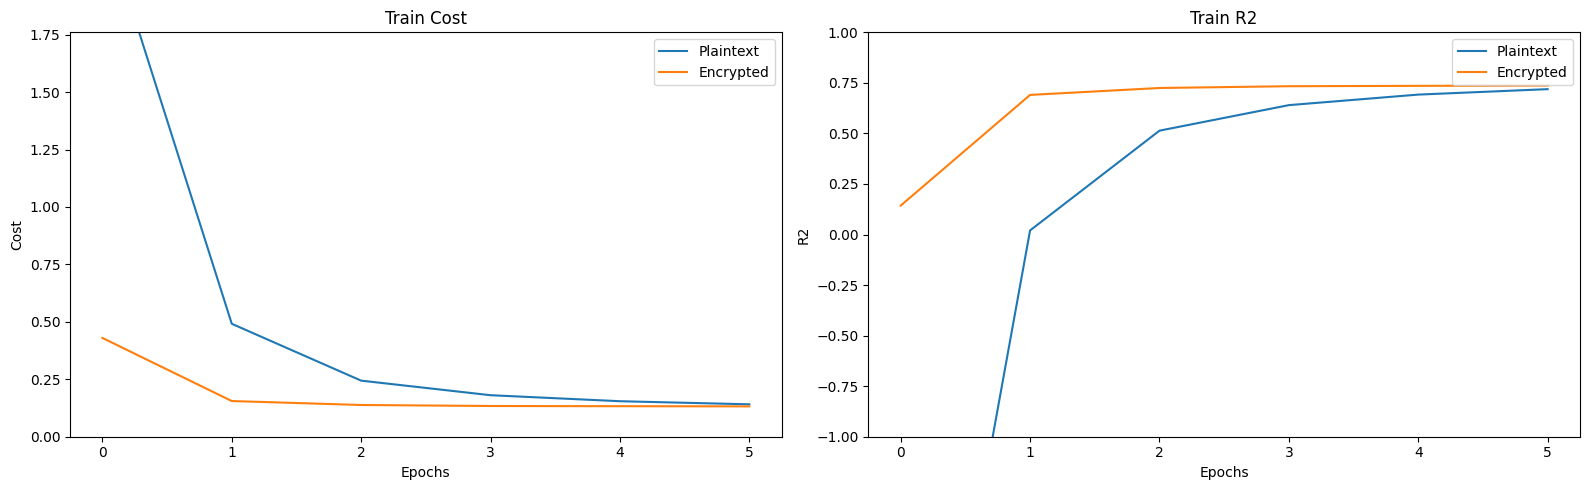

In [52]:
plot_validation_curves(hist_rent, hist_rent_enc)

Finally, the trained encrypted linear regression is evaluated on the test set.

In [53]:
y_pred_rents = predict(X_test_rents, enc_bias, enc_thetas)
r2 = r2_score(y_test_rents, y_pred_rents)
print("R2:", r2)

R2: 0.7301267330201204


## Training of the linear regression model with data read from a file (not evaluated)

To provide a glimpse into the case, how long a linear regression model would be train while reading the encrypted data from a file, modified functions are presented that enable this. Again, this is not the proof of concept subject to evaluation.

Firstly, the context is defined. Thereafter, a public context is created by removing the secret key and writing it to a binary file. This binary file would be provided to MLco in the hypothetical scenario. The code is based on the tests from and TenSEAL library (Ayoub Benaissa and Bilal Retiat and Bogdan Cebere and Alaa Eddine Belfedhal, TenSEAL: A Library for Encrypted Tensor Operations Using Homomorphic Encryption, 2021, 2104.03152m arXiV, visited on 18 May 2024 at https://github.com/OpenMined/TenSEAL/blob/main/tests/python/tenseal/tensors/test_serialization.py) and suggestions from ChatGPT (“How can I efficiently write serialized CKKS vectors into a file?”, ChatGPT (GPT-4o), OpenAI, generated on 18 May 2024)

In [3]:
def context():
    # parameters
    poly_mod_degree = 8192
    coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 40]
    enc_type = ts.ENCRYPTION_TYPE.ASYMMETRIC
    # create TenSEALContext
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes, encryption_type=enc_type)
    context.global_scale = 2 ** 21
    context.generate_galois_keys()
    return context

# save the context with the secret key to keep it persistent. This has to be hidden at 
context = context()
public_context = context.copy()
public_context.make_context_public()

with open("public_context.bin", 'wb') as pub_file:
    pub_file.write(public_context.serialize())

### Encrypt data and write it in batches to a binary file function

The following function encrypt the data in batches and then writes into a binary file. This is the encrypted data that is provided to MLco.

In [4]:
def encrypt_and_serialize_batches(data_X, data_y, batch_size, filename, context):
    num_samples = data_X.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    data_X = data_X[indices]
    data_y = data_y[indices]
    
    with open(filename, 'wb') as file:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            data_batch_X = data_X[start:end]
            data_batch_y = data_y[start:end]
            
            # Encrypt the batch
            enc_train_X = ts.ckks_tensor(context, data_batch_X)
            enc_train_y = ts.ckks_tensor(context, data_batch_y)
            
            # Serialize the encrypted tensors
            serialized_batch_X = enc_train_X.serialize()
            serialized_batch_y = enc_train_y.serialize()
            
            # Write the length of the serialized data and the data itself
            file.write(len(serialized_batch_X).to_bytes(4, byteorder='big'))
            file.write(serialized_batch_X)
            file.write(len(serialized_batch_y).to_bytes(4, byteorder='big'))
            file.write(serialized_batch_y)
            
            # Debug: Print lengths written to file
            # print(f"Batch start: {start}, Batch end: {end} Serialized X length: {len(serialized_batch_X)}, Serialized y length: {len(serialized_batch_y)}")

### Read and decrypt data function

deserialize_decrypt_next_batch function reads the batches from the file one at a time and returns them.

In [5]:
def deserialize_decrypt_next_batch(file, context):
    len_x_bytes = file.read(4)
    if not len_x_bytes:
        return None, None

    len_x = int.from_bytes(len_x_bytes, byteorder='big')
    serialized_batch_X = file.read(len_x)
    
    len_y_bytes = file.read(4)
    len_y = int.from_bytes(len_y_bytes, byteorder='big')
    serialized_batch_y = file.read(len_y)
    
    enc_train_X = ts.ckks_tensor_from(context, serialized_batch_X)
    enc_train_y = ts.ckks_tensor_from(context, serialized_batch_y)
    
    return enc_train_X, enc_train_y

### Encryption of the data

Before providing the data to MLco, the data is encrypted by SRE. WARNING, this will create a file of 170 GB size. The data and the public context is then provided to MLco.

In [6]:
encrypt_and_serialize_batches(X_train_rents[:100], y_train_rents[:100], 100, "enc_dataframe.bin", context)

### Prepare the context for the data owner and the data user

Data owner is SRE from the example. SRE saves its context with the secret key to be able to decrypt the data and the results of operations performed on the data.

The data user us MLco. MLco only receives the public context that only contains the public key. The public context is necessary to reestablish the CKKS vectors from the binary file as packed by SRE.

In [7]:
with open("public_context.bin", 'rb') as pub_file:
    serialized_public_context = pub_file.read()

public_context = ts.context_from(serialized_public_context)

### Modified gradient descent function

Below, we modify the gradient descent function to read batches from the a binary file instead of encrypting the data during training.

In [8]:
def enc_fit_minibatch_readfile(X_train, y_train, alpha, num_epochs, batch_size, file, public_context, context, display_every=1):
    number_features = X_train.shape[1]
    bias = 0.0
    thetas = np.random.randn(*(1, number_features )).reshape(-1)
    reciprocal_N = 1 / batch_size
    
    hist = defaultdict(list)

    for epoch in tqdm(range(1, num_epochs + 1)):
        with open(file, 'rb') as f:
            while True:
                X_train_iteration, y_train_iteration = deserialize_decrypt_next_batch(f, public_context)
                if X_train_iteration is None:
                    break
                grad_bias, grad_thetas = enc_gradient(X_train_iteration, y_train_iteration, bias, thetas, reciprocal_N)
                
                # Decrypt the gradients (occurs at the data owner, SRE as MLco does not have the secret key)
                decrypted_grad_bias = np.array(decrypt(grad_bias, context))
                decrypted_grad_thetas = np.array(decrypt(grad_thetas, context))
                
                # Update parameters
                bias = bias - alpha * decrypted_grad_bias
                thetas = thetas - alpha * decrypted_grad_thetas

        # Log performance
        y_pred_train = predict(X_train, bias, thetas)
        train_cost = cost(y_train, y_pred_train)
        train_r2 = r2_score(y_train, y_pred_train)
        
        hist["train_cost"].append(train_cost)
        hist["train_r2"].append(train_r2)
        
        if epoch % display_every == 0:
            print(f"Epoch {epoch} - cost: {train_cost:.2f} - r2: {train_r2:.4f}")
        
    return bias, thetas, hist

Finally, the training of the linear regression with reading from the file is executed.

In [14]:
len_taken = 10000
batch_size = 100

alpha = 0.01
num_epochs = 6

# measure time
t_start = time()
# measure resource usage
cpu_percent = psutil.cpu_percent()
mem_usage = psutil.Process().memory_info().rss
enc_bias, enc_thetas, hist_rent_enc = enc_fit_minibatch_readfile(X_train_rents[:len_taken], y_train_rents[:len_taken], alpha, num_epochs, batch_size, "enc_dataframe.bin", public_context, context)
cpu_percent_end = psutil.cpu_percent()
mem_usage_end = psutil.Process().memory_info().rss

# Calculate the differences
cpu_diff = cpu_percent_end - cpu_percent
mem_diff = mem_usage_end - mem_usage
t_end = time()
print(f"Training of the Linear Regression took {int(t_end - t_start)} seconds")
print(f"CPU usage difference: {cpu_diff}%")
print(f"Memory usage difference: {mem_diff} bytes")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - cost: 17.33 - r2: -38.7215
Epoch 2 - cost: 15.89 - r2: -35.4295
Epoch 3 - cost: 14.61 - r2: -32.4869
Epoch 4 - cost: 13.46 - r2: -29.8521
Epoch 5 - cost: 12.43 - r2: -27.4878
Training of the Linear Regression took 332 seconds
CPU usage difference: 6.9%
Memory usage difference: 12310495232 bytes
